In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd

from statsmodels.stats.inter_rater import fleiss_kappa as fk
from nltk.metrics.agreement import AnnotationTask

In [7]:
from collections import Counter

In [8]:
#!/usr/bin/env python3

# Copyright (c) Facebook, Inc. and its affiliates.
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.


from mephisto.abstractions.databases.local_database import LocalMephistoDB
# from mephisto.tools.examine_utils import run_examine_or_review, print_results
from mephisto.data_model.worker import Worker
from mephisto.data_model.unit import Unit
from mephisto.data_model.qualification import QUAL_NOT_EXIST
from mephisto.utils.qualifications import make_qualification_dict

# Qualifications
ALLOWLIST_QUALIFICATION = "some_allowlist_qual"

In [9]:
#!/usr/bin/env python3

# Copyright (c) Facebook, Inc. and its affiliates.
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.
"""
Utilities specifically for running examine scripts. Example usage can be
seen in the examine results scripts in the examples directory.
"""

from mephisto.tools.data_browser import DataBrowser
from mephisto.data_model.worker import Worker
from mephisto.utils.qualifications import find_or_create_qualification
import traceback

from typing import TYPE_CHECKING, Optional, Tuple, Callable, Dict, Any, List

if TYPE_CHECKING:
    from mephisto.abstractions.database import MephistoDB
    from mephisto.data_model.unit import Unit


def _get_and_format_data(
    data_browser: "DataBrowser",
    format_data_for_printing: Callable[[Dict[str, Any]], str],
    unit: "Unit",
) -> str:
    """
    Safetly wrapped function to extract the display data string for a specific unit.
    Catches and prints any exceptions.
    """
    formatted = "Error formatting data, see above..."
    try:
        data = data_browser.get_data_from_unit(unit)
        try:
            formatted = format_data_for_printing(data)
        except Exception as e:
            print(f"Unexpected error formatting data for {unit}: {e}")
            # Print the full exception, as this could be user error on the
            # formatting function
            traceback.print_exc()
    except Exception as e:
        print(f"Unexpected error getting data for {unit}: {e}")
    return formatted


def print_results(
    db: "MephistoDB",
    task_name: str,
    format_data_for_printing: Callable[[Dict[str, Any]], str],
    start: Optional[int] = None,
    end: Optional[int] = None,
) -> None:
    """
    Script to write out to stdout from start to end results from the task with the given task name
    """
    data_browser = DataBrowser(db=db)
    units = data_browser.get_units_for_task_name(task_name)
    if end is None:
        end = len(units)
    if start is None:
        start = 0
    units.reverse()
    for unit in units[start:end]:
        print(_get_and_format_data(data_browser, format_data_for_printing, unit))


def prompt_for_options(
    task_name: Optional[str] = None,
    block_qualification: Optional[str] = None,
    approve_qualification: Optional[str] = None,
) -> Tuple[str, Optional[str], Optional[str]]:
    """
    Utility to request common user options for examine scripts.
    Leave `block_qualification` or `approve_qualification` as empty strings
    to skip their respective prompt.
    """
    if task_name is None:
        task_name = input("Input task name: ")
    if block_qualification is None:
        block_qualification = input(
            "If you'd like to soft-block workers, you'll need a block qualification. "
            "Leave blank otherwise.\nEnter block qualification: "
        )
    if approve_qualification is None:
        approve_qualification = input(
            "If you'd like to qualify high-quality workers, you'll need an approve "
            "qualification. Leave blank otherwise.\nEnter approve qualification: "
        )
    if len(block_qualification.strip()) == 0:
        block_qualification = None
    if len(approve_qualification.strip()) == 0:
        approve_qualification = None
    input(
        "Starting review with following params:\n"
        f"Task name: {task_name}\n"
        f"Blocking qualification: {block_qualification}\n"
        f"Approve qualification: {approve_qualification}\n"
        "Press enter to continue... "
    )
    return task_name, block_qualification, approve_qualification


def get_worker_stats(units: List["Unit"]) -> Dict[str, Dict[str, List["Unit"]]]:
    """
    Traverse a list of units and create a mapping from worker id
    to their units, grouped by their current status
    """
    previous_work_by_worker: Dict[str, Dict[str, List["Unit"]]] = {}
    for unit in units:
        w_id = unit.worker_id
        if w_id not in previous_work_by_worker:
            previous_work_by_worker[w_id] = {
                "accepted": [],
                "soft_rejected": [],
                "rejected": [],
            }
        previous_work_by_worker[w_id][unit.get_status()].append(unit)
    return previous_work_by_worker




def format_worker_stats(
    worker_id: str, previous_work_by_worker: Dict[str, Dict[str, List["Unit"]]]
) -> str:
    """
    When given a worker id and a list of worker stats, return a string
    containing the proportion of accepted to rejected work.
    """
    prev_work = previous_work_by_worker.get(worker_id)
    if prev_work is None:
        return "(First time worker!)"
    accepted_work = len(prev_work["accepted"])
    soft_rejected_work = len(prev_work["soft_rejected"])
    rejected_work = len(prev_work["rejected"])
    return f"({accepted_work} | {rejected_work + soft_rejected_work}({soft_rejected_work}) / {accepted_work + soft_rejected_work + rejected_work})"


def run_examine_by_worker(
    db: "MephistoDB",
    format_data_for_printing: Callable[[Dict[str, Any]], str],
    task_name: Optional[str] = None,
    block_qualification: Optional[str] = None,
    approve_qualification: Optional[str] = None,
):
    """
    Basic script for reviewing work, grouped by worker for convenience. First gets
    the required information to run a review, then
    """
    data_browser = DataBrowser(db=db)

    # Get initial arguments
    if task_name is None:
        task_name, block_qualification, approve_qualification = prompt_for_options(
            task_name, block_qualification, approve_qualification
        )

    tasks = db.find_tasks(task_name=task_name)
    assert len(tasks) >= 1, f"No task found under name {task_name}"

    print(
        "You will be reviewing actual tasks with this flow. Tasks that you either Accept or Pass "
        "will be paid out to the worker, while rejected tasks will not. Passed tasks will be "
        "specially marked such that you can leave them out of your dataset. \n"
        "You may enter the option in caps to apply it to the rest of the units for a given worker."
    )
    if block_qualification is not None:
        created_block_qual = find_or_create_qualification(db, block_qualification)
        print(
            "When you pass or reject a task, the script gives you an option to disqualify the worker "
            "from future tasks by assigning a qualification. If provided, this worker will no "
            "longer be able to work on tasks where the set --block-qualification shares the same name "
            f"you provided above: {block_qualification}\n"
        )
    if approve_qualification is not None:
        created_approve_qual = find_or_create_qualification(db, approve_qualification)
        print(
            "You may use this script to establish a qualified worker pool by granting the provided "
            f"approve qualification {approve_qualification} to workers you think understand the task "
            "well. This will be provided as an option for workers you (A)pprove all on. "
            "Future tasks can use this qual as a required qualification, as described in the "
            "common qualification flows document."
        )
    print(
        "**************\n"
        "You should only reject tasks when it is clear the worker has acted in bad faith, and "
        "didn't actually do the task. Prefer to pass on tasks that were misunderstandings.\n"
        "**************\n"
    )

    units = data_browser.get_units_for_task_name(task_name)

    others = [u for u in units if u.get_status() != "completed"]
    units = [u for u in units if u.get_status() == "completed"]
    reviews_left = len(units)
    previous_work_by_worker = get_worker_stats(others)

    # Determine allowed options
    options = ["a", "p", "r"]
    options_string = "Do you want to accept this work? (a)ccept, (r)eject, (p)ass:"

    units_by_worker: Dict[str, List["Unit"]] = {}

    for u in units:
        w_id = u.worker_id
        if w_id not in units_by_worker:
            units_by_worker[w_id] = []
        units_by_worker[w_id].append(u)

    # Run the review
    for w_id, w_units in units_by_worker.items():
        worker = Worker.get(db, w_id)
        worker_name = worker.worker_name
        apply_all_decision = None
        reason = None
        for idx, unit in enumerate(w_units):

            print(
                f"Reviewing for worker {worker_name}, ({idx+1}/{len(w_units)}), "
                f"Previous {format_worker_stats(w_id, previous_work_by_worker)} "
                f"(total remaining: {reviews_left})"
            )
            reviews_left -= 1
            print(format_data_for_printing(data_browser.get_data_from_unit(unit)))
            if apply_all_decision is not None:
                decision = apply_all_decision
            else:
                decision = input(
                    "Do you want to accept this work? (a)ccept, (r)eject, (p)ass: "
                )
            while decision.lower() not in options:
                decision = input(
                    "Decision must be one of a, p, r. Use CAPS to apply to all remaining for worker: "
                )

            agent = unit.get_assigned_agent()
            assert (
                agent is not None
            ), f"Can't make decision on None agent... issue with {unit}"
            if decision.lower() == "a":
                agent.approve_work()
                if decision == "A" and approve_qualification is not None:
                    should_special_qualify = input(
                        "Do you want to approve qualify this worker? (y)es/(n)o: "
                    )
                    if should_special_qualify.lower() in ["y", "yes"]:
                        worker.grant_qualification(approve_qualification, 1)
            elif decision.lower() == "p":
                agent.soft_reject_work()
                if apply_all_decision is None and block_qualification is not None:
                    should_soft_block = input(
                        "Do you want to soft block this worker? (y)es/(n)o: "
                    )
                    if should_soft_block.lower() in ["y", "yes"]:
                        worker.grant_qualification(block_qualification, 1)
            else:  # decision = 'r'
                if apply_all_decision is None:
                    reason = input("Why are you rejecting this work? ")
                    should_block = input(
                        "Do you want to hard block this worker? (y)es/(n)o: "
                    )
                    if should_block.lower() in ["y", "yes"]:
                        block_reason = input("Why permanently block this worker? ")
                        worker.block_worker(block_reason)
                agent.reject_work(reason)

            if decision.lower() != decision:
                apply_all_decision = decision.lower()


def run_examine_or_review(
    db: "MephistoDB",
    format_data_for_printing: Callable[[Dict[str, Any]], str],
) -> None:
    do_review = input(
        "Do you want to (r)eview, or (e)xamine data? Default "
        "examine. Can put e <end> or e <start> <end> to choose "
        "how many to view\n"
    )

    if do_review.lower().startswith("r"):
        run_examine_by_worker(db, format_data_for_printing)
    else:
        start = 0
        end = None
        opts = do_review.split(" ")
        if len(opts) == 2:
            end = int(opts[1])
        elif len(opts) == 3:
            start = int(opts[1])
            end = int(opts[2])
        task_name = input("Input task name: ")
        print_results(db, task_name, format_data_for_printing, start=start, end=end)


0<h2>Start Here<h2>

In [12]:
global db
db = LocalMephistoDB()

In [13]:
all_units = []


In [14]:
data_browser = DataBrowser(db=db)
task_name = "med585-v1" #"ass510-v5"
all_units = data_browser.get_units_for_task_name(task_name)

In [21]:
# generete a dictionary of workers and a dictionary or units
all_workers = {}
all_questions = {}
all_quality_qs = {}


In [22]:
len(all_quality_qs)

0

New


In [23]:
for unit in all_units:
    data = data_browser.get_data_from_unit(unit)
    contents = data["data"]
    q_id = contents['inputs']["qid"]
    
    if q_id.startswith('q_') :
        if q_id not in all_quality_qs:
            all_quality_qs[q_id] = len(all_quality_qs)
            
    elif q_id not in all_questions:
        all_questions[q_id] = len(all_questions)
    else:
        pass # already seen this question id
    
    if unit.worker_id not in all_workers:
        all_workers[unit.worker_id] = len(all_workers)
    

In [27]:
answers_per_worker = Counter([unit.worker_id for unit in all_units])
answers_per_worker

Counter({'286': 25,
         '291': 1,
         '327': 12,
         '303': 25,
         '325': 24,
         '333': 4,
         '335': 25,
         '336': 24,
         '338': 21,
         '339': 17,
         '340': 1,
         '301': 11,
         '344': 3})

In [30]:
answers_per_question = Counter([data_browser.get_data_from_unit(unit)["data"]['inputs']['qid'] for unit in all_units])
answers_per_question

Counter({'69': 1,
         '196': 2,
         '142': 1,
         'q_0': 3,
         '153': 3,
         '7': 3,
         '11': 4,
         '155': 4,
         '203': 4,
         'q_4': 4,
         '44': 5,
         '149': 3,
         '20': 5,
         '146': 5,
         '77': 5,
         '64': 4,
         'q_5': 5,
         '49': 5,
         '188': 4,
         '169': 4,
         '129': 4,
         '41': 4,
         'q_1': 5,
         '207': 5,
         '35': 5,
         '138': 5,
         '164': 5,
         '211': 5,
         'q_3': 5,
         '159': 4,
         '185': 5,
         '133': 5,
         '168': 5,
         '135': 5,
         'q_6': 4,
         '22': 5,
         '112': 5,
         '141': 5,
         '42': 4,
         '80': 4,
         'q_7': 4,
         '99': 4,
         '68': 5,
         '175': 5,
         '76': 4,
         '209': 3})

In [32]:
len(all_units)

193

In [33]:
others = [u for u in all_units if u.get_status() != "completed"]
units = [u for u in all_units if u.get_status() == "completed"]
reviews_left = len(units)
previous_work_by_worker = get_worker_stats(others)

In [34]:
questions_answered = {}
answers_to_quality_questions = {}
time_2_answer = {}

def exclude_annotated() -> None:
    for unit in all_units:
        data = data_browser.get_data_from_unit(unit)
        contents = data["data"]
        q_id = contents['inputs']["qid"]
        
        # if q_id in ['0', 'q_0']: quality question
        if q_id.startswith('q_'): # quality question
            try:
                answers_to_quality_questions[unit.worker_id].append( contents['outputs']['answers']) 
            except:
                answers_to_quality_questions[unit.worker_id]     = [ contents['outputs']['answers']]
        else:
            try: 
                questions_answered[q_id] += 1
            except:
                questions_answered[q_id] = 1
        
        ttaken = data['task_end'] - data['task_start']
        try:
            time_2_answer[unit.worker_id].append(ttaken) 
        except:
            time_2_answer[unit.worker_id]     = [ttaken]

In [35]:
exclude_annotated()

In [37]:
questions_answered

{'69': 1,
 '196': 2,
 '142': 1,
 '153': 3,
 '7': 3,
 '11': 4,
 '155': 4,
 '203': 4,
 '44': 5,
 '149': 3,
 '20': 5,
 '146': 5,
 '77': 5,
 '64': 4,
 '49': 5,
 '188': 4,
 '169': 4,
 '129': 4,
 '41': 4,
 '207': 5,
 '35': 5,
 '138': 5,
 '164': 5,
 '211': 5,
 '159': 4,
 '185': 5,
 '133': 5,
 '168': 5,
 '135': 5,
 '22': 5,
 '112': 5,
 '141': 5,
 '42': 4,
 '80': 4,
 '99': 4,
 '68': 5,
 '175': 5,
 '76': 4,
 '209': 3}

In [40]:
answers_to_quality_questions

{'286': ['0', '0', '0', '1'],
 '327': ['0.5', '0'],
 '303': ['0.5', '0', '0', '1'],
 '333': ['0'],
 '325': ['0', '0', '1', '0'],
 '335': ['0', '1', '0', '0'],
 '338': ['1', '0', '0', '0', '0.5'],
 '336': ['0', '0', '0.5'],
 '339': ['0', '0.5'],
 '301': ['0.5']}

In [41]:
np.average(time_2_answer['286'])

17.76694221496582

In [42]:
[np.average(time_2_answer[k]) for k in time_2_answer.keys()]

[17.76694221496582,
 244.71854519844055,
 63.119007686773934,
 26.37734679222107,
 61.21983631451925,
 33.86508935689926,
 13.98723355293274,
 31.756679793198902,
 326.90083397002445,
 42.14306442877825,
 50.80405783653259,
 25.413878787647594,
 69.60129149754842]

In [43]:
np.average([np.average(time_2_answer[k]) for k in time_2_answer.keys()]), np.std([np.average(time_2_answer[k]) for k in time_2_answer.keys()])

(77.51336980234484, 91.81281298398477)

In [44]:
time_2_answer.keys(), [np.average(time_2_answer[k]) for k in time_2_answer.keys()]

(dict_keys(['286', '291', '327', '303', '325', '333', '335', '336', '338', '339', '340', '301', '344']),
 [17.76694221496582,
  244.71854519844055,
  63.119007686773934,
  26.37734679222107,
  61.21983631451925,
  33.86508935689926,
  13.98723355293274,
  31.756679793198902,
  326.90083397002445,
  42.14306442877825,
  50.80405783653259,
  25.413878787647594,
  69.60129149754842])

In [45]:
np.mean([np.average(time_2_answer[k]) for k in time_2_answer.keys()]), np.std([np.average(time_2_answer[k]) for k in time_2_answer.keys()])

(77.51336980234484, 91.81281298398477)

In [46]:
max(time_2_answer['286'])//60 +1 

3.0

In [47]:
[ (np.min(time_2_answer[k])//60) +1 for k in time_2_answer.keys()] 

[1.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [48]:
previous_work_by_worker['286']['accepted'][0]

KeyError: '286'

In [49]:
all_workers = None
all_workers = {}
questions = None 
questions = {}


In [50]:
for unit in all_units:
        
    worker_name = Worker.get(db, unit.worker_id).worker_name
    try:        
        all_workers[worker_name] +=1
    except:
        all_workers[worker_name] =1

    data = data_browser.get_data_from_unit(unit)    
    contents = data["data"]
    duration = contents["times"]["task_end"] - contents["times"]["task_start"]
    metadata_string = (
        f"Worker: {worker_name}\nUnit: {data['unit_id']}\n"
        f"Duration: {int(duration)}\nStatus: {data['status']}\n"
    )
    q_id  = contents['inputs']["qid"]


    inputs = contents["inputs"]
    # print(inputs)
    inputs_string = f"Origin:\t{inputs['original']}\nAnony.:\t{inputs['anon_sent']}\n"

    outputs = contents["outputs"]
    output_string = f"   Answer: {outputs['answers']}\n" if 'answers' in outputs.keys() else f"   Answer: None\n"

    try:
        questions[q_id].append(outputs['answers'])
    except:
        questions[q_id] =[outputs['answers']]  

In [51]:
all_workers

{'ABMPX2Y2IRBMG': 25,
 'A2YO837C0O1E91': 1,
 'A1BAEFJ2OG7NJ0': 12,
 'A2FV0CMG9S8CU0': 25,
 'AJDXSXAWDDAEO': 24,
 'A3MZ9RQJX9T656': 4,
 'A9HQ3E0F2AGVO': 25,
 'A3I9XLIHPPWPN1': 24,
 'AE861G0AY5RGT': 21,
 'A37WXDYYT7RCZ0': 17,
 'A264NN7JBX4UDQ': 1,
 'A32CMQGGTSUK6Z': 11,
 'A2WNW8A4MOR7T7': 3}

In [69]:
sampled_questions = {}
for Q in questions:
    if len(questions[Q]) > 3 and not Q.startswith('q_'):
        sampled_questions[Q] = list(np.random.choice(questions[Q], size=4))
    else:
        pass

In [61]:
sampled_questions

{'11': ['1', '0.5', '0.5', '1'],
 '155': ['1', '1', '1', '0.5'],
 '203': ['0.5', '0.5', '0.5', '0.5'],
 '44': ['0.5', '1', '1', '1'],
 '20': ['1', '1', '1', '1'],
 '146': ['1', '1', '1', '1'],
 '77': ['1', '1', '1', '1'],
 '64': ['0.5', '0.5', '1', '0.5'],
 '49': ['1', '1', '1', '1'],
 '188': ['1', '0.5', '1', '1'],
 '169': ['1', '0.5', '0.5', '0.5'],
 '129': ['1', '1', '1', '1'],
 '41': ['0.5', '1', '0.5', '1'],
 '207': ['0.5', '0.5', '1', '0.5'],
 '35': ['1', '1', '1', '1'],
 '138': ['1', '1', '1', '1'],
 '164': ['1', '1', '1', '1'],
 '211': ['1', '1', '1', '1'],
 '159': ['1', '1', '1', '1'],
 '185': ['0.5', '1', '1', '0'],
 '133': ['1', '1', '1', '1'],
 '168': ['0.5', '0.5', '0.5', '0.5'],
 '135': ['1', '0', '0.5', '1'],
 '22': ['0.5', '1', '0.5', '1'],
 '112': ['1', '1', '1', '1'],
 '141': ['1', '1', '1', '1'],
 '42': ['0', '0.5', '0.5', '0'],
 '80': ['1', '1', '1', '1'],
 '99': ['1', '0.5', '0.5', '0.5'],
 '68': ['1', '1', '1', '1'],
 '175': ['1', '1', '1', '1'],
 '76': ['0.5', '0

In [62]:
all_workers.values(), sum(all_workers.values()), questions.values(), len(questions.values())


(dict_values([25, 1, 12, 25, 24, 4, 25, 24, 21, 17, 1, 11, 3]),
 193,
 dict_values([['1'], ['0.5', '1'], ['1'], ['0', '0.5', '0.5'], ['1', '1', '1'], ['1', '1', '1'], ['1', '0.5', '1', '1'], ['1', '0.5', '1', '1'], ['1', '0.5', '0.5', '0.5'], ['0', '0', '0', '0'], ['1', '0.5', '1', '1', '1'], ['1', '0.5', '1'], ['1', '1', '1', '1', '1'], ['1', '1', '1', '1', '1'], ['1', '1', '1', '1', '1'], ['0.5', '0.5', '1', '0.5'], ['0', '0', '0', '0', '0'], ['1', '1', '1', '1', '1'], ['1', '0.5', '0.5', '1'], ['0.5', '0.5', '0.5', '1'], ['1', '1', '1', '1'], ['1', '0.5', '0.5', '0.5'], ['1', '1', '1', '1', '1'], ['1', '0.5', '0.5', '1', '1'], ['1', '1', '0.5', '1', '1'], ['1', '1', '1', '1', '1'], ['1', '1', '1', '1', '1'], ['1', '1', '1', '1', '1'], ['0', '0', '0', '0', '0'], ['1', '1', '1', '1'], ['0.5', '1', '0.5', '0.5', '0'], ['1', '1', '1', '1', '1'], ['1', '0.5', '0.5', '0.5', '0.5'], ['0.5', '0', '0.5', '0.5', '1'], ['0', '0', '0', '0'], ['0.5', '0.5', '0.5', '1', '1'], ['1', '1', '1', '1',

Source for Fleiss Kappa:

https://towardsdatascience.com/inter-annotator-agreement-2f46c6d37bf3

<img src="/media/malik/sharedArea/CodesNstuff/Mephisto/QaTask/examples/simple_static_task/kappa.png">


In [63]:
def fleiss_kappa(M):
    """Computes Fleiss' kappa for group of annotators.

    :param M: a matrix of shape (:attr:'N', :attr:'k') with 'N' = number of subjects and 'k' = the number of categories.
        'M[i, j]' represent the number of raters who assigned the 'i'th subject to the 'j'th category.
    :type: numpy matrix

    :rtype: float
    :return: Fleiss' kappa score
    """
    N, k = M.shape  # N is # of items, k is # of categories
    n_annotators = float(np.sum(M[0, :]))  # # of annotators
    tot_annotations = N * n_annotators  # the total # of annotations
    category_sum = np.sum(M, axis=0)  # the sum of each category over all items

    # chance agreement
    p = category_sum / tot_annotations  # the distribution of each category over all annotations
    PbarE = np.sum(p * p)  # average chance agreement over all categories

    # observed agreement
    P = (np.sum(M * M, axis=1) - n_annotators) / (n_annotators * (n_annotators - 1))
    Pbar = np.sum(P) / N  # add all observed agreement chances per item and divide by amount of items

    return round((Pbar - PbarE) / (1 - PbarE), 4)

In [70]:
m = np.zeros((len(sampled_questions), 3))
def gen_m(sampled_questions):
    for i, q in enumerate(sampled_questions):
        # print(i, sampled_questions[q])
        m[i][0] = sampled_questions[q].count('0')
        m[i][1] = sampled_questions[q].count('0.5')
        m[i][2] = sampled_questions[q].count('1')
        # break
    return m

m = gen_m(sampled_questions)        
m

array([[0., 1., 3.],
       [0., 1., 3.],
       [0., 4., 0.],
       [0., 1., 3.],
       [0., 0., 4.],
       [0., 0., 4.],
       [0., 0., 4.],
       [0., 4., 0.],
       [0., 0., 4.],
       [0., 3., 1.],
       [0., 3., 1.],
       [0., 0., 4.],
       [0., 4., 0.],
       [0., 1., 3.],
       [0., 1., 3.],
       [0., 0., 4.],
       [0., 0., 4.],
       [0., 0., 4.],
       [0., 0., 4.],
       [0., 4., 0.],
       [0., 0., 4.],
       [0., 4., 0.],
       [1., 3., 0.],
       [0., 2., 2.],
       [0., 0., 4.],
       [0., 0., 4.],
       [1., 1., 2.],
       [0., 0., 4.],
       [0., 4., 0.],
       [0., 0., 4.],
       [0., 0., 4.],
       [2., 2., 0.]])

In [71]:
fleiss_kappa(np.array(m))

0.6033

In [73]:
fk(m,method='fleiss')

0.6032503979224262

In [74]:
m_percentage = m/np.sum(m, axis=1)[:,None]
m_percentage

array([[0.  , 0.25, 0.75],
       [0.  , 0.25, 0.75],
       [0.  , 1.  , 0.  ],
       [0.  , 0.25, 0.75],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.75, 0.25],
       [0.  , 0.75, 0.25],
       [0.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 0.25, 0.75],
       [0.  , 0.25, 0.75],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  ],
       [0.25, 0.75, 0.  ],
       [0.  , 0.5 , 0.5 ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [0.25, 0.25, 0.5 ],
       [0.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [0.5 , 0.5 , 0.  ]])

In [76]:
r = range(len(sampled_questions))
raw_data = {'greenBars': list(m[:,0]), 'orangeBars': list(m[:,1]),'blueBars': list(m[:,2])}
df = pd.DataFrame(raw_data)

# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['greenBars'], df['orangeBars'], df['blueBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]
blueBars = [i / j * 100 for i,j in zip(df['blueBars'], totals)]

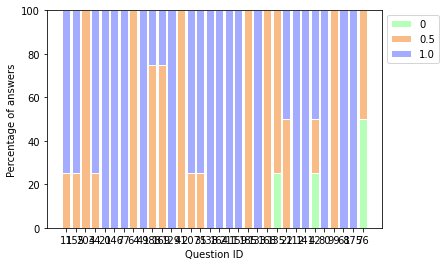

In [77]:
# plot
barWidth = 0.85
names = sampled_questions.keys()
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth, label="0")
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth, label="0.5")
# Create blue Bars
plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth, label="1.0")

# Custom x axis
plt.xticks(r, names)
plt.xlabel("Question ID") 
plt.ylabel("Percentage of answers")

# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# Show graphic
plt.show()

1<h1>My Answers<h1>


In [81]:
task_name = "maleks-85a"
my_units = data_browser.get_units_for_task_name(task_name)

In [84]:
my_units

[MockUnit(313, completed),
 MockUnit(314, completed),
 MockUnit(315, completed),
 MockUnit(316, completed),
 MockUnit(317, completed),
 MockUnit(318, completed),
 MockUnit(319, completed),
 MockUnit(320, completed),
 MockUnit(321, completed),
 MockUnit(322, completed),
 MockUnit(323, completed),
 MockUnit(324, completed),
 MockUnit(325, completed),
 MockUnit(326, completed),
 MockUnit(327, completed),
 MockUnit(328, completed),
 MockUnit(329, completed),
 MockUnit(330, completed),
 MockUnit(331, completed),
 MockUnit(332, completed),
 MockUnit(333, completed),
 MockUnit(334, completed),
 MockUnit(335, completed),
 MockUnit(336, completed),
 MockUnit(337, completed),
 MockUnit(338, completed),
 MockUnit(339, completed),
 MockUnit(340, completed),
 MockUnit(341, completed),
 MockUnit(342, completed),
 MockUnit(343, completed),
 MockUnit(344, completed),
 MockUnit(345, completed),
 MockUnit(346, completed),
 MockUnit(347, completed),
 MockUnit(348, completed),
 MockUnit(349, completed),
 

In [138]:
my_answers_per_question ={}
my__quality_qs = {}
for unit in my_units:
    data = data_browser.get_data_from_unit(unit)
    contents = data["data"]
    q_id = contents['inputs']["qid"]
    
    if q_id.startswith('q_') :
        if q_id not in my__quality_qs:
            my__quality_qs[q_id] = len(my__quality_qs)
            
    elif q_id not in my__quality_qs:
        outputs = contents["outputs"]
        my_answers_per_question[q_id] = outputs['answers']

my_answers_per_question

{'138': '1',
 '211': '1',
 '112': '1',
 '164': '1',
 '49': '1',
 '175': '1',
 '117': '1',
 '7': '1',
 '80': '1',
 '159': '1',
 '76': '0',
 '209': '0',
 '141': '1',
 '149': '0.5',
 '142': '1',
 '68': '1',
 '188': '0.5',
 '44': '1',
 '129': '1',
 '207': '1',
 '153': '1',
 '196': '0',
 '135': '0',
 '77': '1',
 '169': '0',
 '155': '0',
 '42': '0.5',
 '35': '1',
 '99': '0',
 '41': '0',
 '22': '0.5',
 '203': '0',
 '69': '1',
 '146': '1',
 '64': '1',
 '11': '0',
 '20': '1',
 '133': '1',
 '168': '1',
 '185': '0.5'}

In [147]:
contents['inputs']['tech']

'atten'

Calculate the accuracy

In [87]:
sampled_questions

{'11': ['1', '0.5', '1', '1'],
 '155': ['1', '1', '1', '0.5'],
 '203': ['0.5', '0.5', '0.5', '0.5'],
 '44': ['1', '1', '1', '0.5'],
 '20': ['1', '1', '1', '1'],
 '146': ['1', '1', '1', '1'],
 '77': ['1', '1', '1', '1'],
 '64': ['0.5', '0.5', '0.5', '0.5'],
 '49': ['1', '1', '1', '1'],
 '188': ['0.5', '1', '0.5', '0.5'],
 '169': ['0.5', '0.5', '0.5', '1'],
 '129': ['1', '1', '1', '1'],
 '41': ['0.5', '0.5', '0.5', '0.5'],
 '207': ['0.5', '1', '1', '1'],
 '35': ['1', '1', '1', '0.5'],
 '138': ['1', '1', '1', '1'],
 '164': ['1', '1', '1', '1'],
 '211': ['1', '1', '1', '1'],
 '159': ['1', '1', '1', '1'],
 '185': ['0.5', '0.5', '0.5', '0.5'],
 '133': ['1', '1', '1', '1'],
 '168': ['0.5', '0.5', '0.5', '0.5'],
 '135': ['0.5', '0.5', '0.5', '0'],
 '22': ['0.5', '1', '0.5', '1'],
 '112': ['1', '1', '1', '1'],
 '141': ['1', '1', '1', '1'],
 '42': ['0', '0.5', '1', '1'],
 '80': ['1', '1', '1', '1'],
 '99': ['0.5', '0.5', '0.5', '0.5'],
 '68': ['1', '1', '1', '1'],
 '175': ['1', '1', '1', '1'],
 

In [ ]:
sum_qs = 0
total = 0
for q in sampled_questions:
    sum_qs +=  sampled_questions[q].count(my_answers_per_question[q])
    total += 5
    print(q, sampled_questions[q].count(my_answers_per_question[q]))
print(sum_qs, total, '\nAverage:', sum_qs/total)

In [ ]:
all_tuples = []
for unit in all_units:
        
    worker_name = Worker.get(db, unit.worker_id).worker_name
    

    data = data_browser.get_data_from_unit(unit)    
    contents = data["data"]
    duration = contents["times"]["task_end"] - contents["times"]["task_start"]
    metadata_string = (
        f"Worker: {worker_name}\nUnit: {data['unit_id']}\n"
        f"Duration: {int(duration)}\nStatus: {data['status']}\n"
    )
    q_id  = contents['inputs']["qid"]
    outputs = contents["outputs"]
    outputs['answers']

    print(worker_name, q_id, outputs['answers'])
    all_tuples.append((worker_name, q_id, outputs['answers']))
    # break

In [157]:
q_type_tuples = {}
for unit in all_units:
        
    worker_name = Worker.get(db, unit.worker_id).worker_name
    

    data = data_browser.get_data_from_unit(unit)    
    contents = data["data"]
    duration = contents["times"]["task_end"] - contents["times"]["task_start"]
    metadata_string = (
        f"Worker: {worker_name}\nUnit: {data['unit_id']}\n"
        f"Duration: {int(duration)}\nStatus: {data['status']}\n"
    )
    q_id  = contents['inputs']["qid"]
    # outputs = contents["outputs"]
    # outputs['answers']

    # print(worker_name, q_id, outputs['answers'])
    q_type_tuples[q_id] = contents['inputs']['tech']
    # break

In [158]:
q_type_tuples

{'69': 'BT',
 '196': 'mutX',
 '142': 'AStar',
 'q_0': 'atten',
 '153': 'mutX',
 '7': 'Orig',
 '11': 'BT',
 '155': 'LSB',
 '203': 'LSB',
 'q_4': 'atten',
 '44': 'mutX',
 '149': 'AStar',
 '20': 'BT',
 '146': 'BT',
 '77': 'mutX',
 '64': 'BT',
 'q_5': 'atten',
 '49': 'Orig',
 '188': 'mutX',
 '169': 'LSB',
 '129': 'mutX',
 '41': 'LSB',
 'q_1': 'atten',
 '207': 'mutX',
 '35': 'LSB',
 '138': 'Orig',
 '164': 'Orig',
 '211': 'Orig',
 'q_3': 'atten',
 '159': 'AStar',
 '185': 'BT',
 '133': 'BT',
 '168': 'BT',
 '135': 'mutX',
 'q_6': 'atten',
 '22': 'LSB',
 '112': 'Orig',
 '141': 'AStar',
 '42': 'LSB',
 '80': 'AStar',
 'q_7': 'atten',
 '99': 'LSB',
 '68': 'AStar',
 '175': 'Orig',
 '76': 'AStar',
 '209': 'AStar'}

In [161]:
"""

0<---------0.5----------->1

"""

def myDistance(k1, k2):
    if k1 == k2:
        return 0
    elif (k1, k2) == ('0.5', '1') or (k1, k2) == ('1', '0.5'):
        return  0.5
    elif (k1, k2) == ('0', '0.5') or (k1, k2) == ('0.5', '0'):
        return 1
    else : # ('0', '1', 1)
        return 1
    
# task = AnnotationTask(data=[('c1', '1', 'v1'),('c2', '1', 'v1'),...])
task = AnnotationTask(data=all_tuples,distance=myDistance)
task.alpha()

0.5717103409411102

In [134]:
from nltk.metrics.distance import binary_distance
binary_distance('0', '1')

1.0

Qualitative analysis
"41",
"Another issue is the added levels of coordination that occur when working with multiple aid groups to ensure healthcare service coverage.",
"Another concern is - added levels of coordination that occur when working with multiple aid groups to ensure full service coverage.","LSB"

In [139]:
my_answers_per_question['41']

'0'

In [144]:
pd_data = pd.DataFrame.from_dict(sampled_questions, orient='index', columns='C1, C2, C3, C4'.split(', '))
pd_data

,C1,C2,C3,C4
11,1,0.5,1,1
155,1,1,1,0.5
203,0.5,0.5,0.5,0.5
44,1,1,1,0.5
20,1,1,1,1
146,1,1,1,1
77,1,1,1,1
64,0.5,0.5,0.5,0.5
49,1,1,1,1
188,0.5,1,0.5,0.5


In [146]:
pd_data['my_answer'] = pd_data.index.map(my_answers_per_question)
pd_data

,C1,C2,C3,C4,my_answer
11,1,0.5,1,1,0
155,1,1,1,0.5,0
203,0.5,0.5,0.5,0.5,0
44,1,1,1,0.5,1
20,1,1,1,1,1
146,1,1,1,1,1
77,1,1,1,1,1
64,0.5,0.5,0.5,0.5,1
49,1,1,1,1,1
188,0.5,1,0.5,0.5,0.5


In [159]:
pd_data['my_answer'] = pd_data.index.map(q_type_tuples)
pd_data

,C1,C2,C3,C4,my_answer
11,1,0.5,1,1,BT
155,1,1,1,0.5,LSB
203,0.5,0.5,0.5,0.5,LSB
44,1,1,1,0.5,mutX
20,1,1,1,1,BT
146,1,1,1,1,BT
77,1,1,1,1,mutX
64,0.5,0.5,0.5,0.5,BT
49,1,1,1,1,Orig
188,0.5,1,0.5,0.5,mutX


>>>New Work here


In [1]:
pd_data

NameError: name 'pd_data' is not defined